In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
from tqdm import tqdm
import random
import gym
from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different. 
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
import gym
env = gym.make('Taxi-v3')

#env.seed(0)

state_shape = env.observation_space
no_of_actions = env.action_space.n

print("State shape:", state_shape)
print("Number of Actions: ",no_of_actions)
print("Sampled Action",env.action_space.sample())
print("----"*20)

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''
Passenger_locations = {0:"R(ed)",1:"G(reen)",2:"Y(ellow)",3:"B(lue)",4:"in taxi"}
Destinations = {0:"R(ed)",1:"G(reen)",2:"Y(ellow)",3:"B(lue)"}
Actions = {0: "move south", 1: "move north", 2: "move east", 3: "move west", 4: "pickup passenger",5: "drop off passenger"}
print("Actions: ",Actions)
print("Passenger_locations: ",Passenger_locations)
print("Destinations: ",Destinations)
print("----"*20)
state = env.reset()
''' This returns the initial state (when environment is reset) '''

print("Current_State: ",state)
print("Decoded Current_State [taxi_row, taxi_col, passenger_location, destination]: ",list(env.decode(state)))
print(env.render())
print("----"*20)

action = env.action_space.sample()
''' We take a random action now '''

print("Sampled Action: ", action)
print("----"*20)

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print("Next_State: ",next_state)
print("Decoded Next_State [taxi_row, taxi_col, passenger_location, destination]: ",list(env.decode(next_state)))
print("Reward: ",reward)
print("Done: ", done)
print("Info: ", info)
print("----"*20)

print(env.render())
print("----"*20)

State shape: Discrete(500)
Number of Actions:  6
Sampled Action 5
--------------------------------------------------------------------------------
Actions:  {0: 'move south', 1: 'move north', 2: 'move east', 3: 'move west', 4: 'pickup passenger', 5: 'drop off passenger'}
Passenger_locations:  {0: 'R(ed)', 1: 'G(reen)', 2: 'Y(ellow)', 3: 'B(lue)', 4: 'in taxi'}
Destinations:  {0: 'R(ed)', 1: 'G(reen)', 2: 'Y(ellow)', 3: 'B(lue)'}
--------------------------------------------------------------------------------
Current_State:  328
Decoded Current_State [taxi_row, taxi_col, passenger_location, destination]:  [3, 1, 2, 0]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

None
--------------------------------------------------------------------------------
Sampled Action:  1
--------------------------------------------------------------------------------
Next_State:  228
Decoded Next_State [taxi_row, taxi_col, passenger_location, destination]:  [2, 1, 2, 0]

In [3]:
#Update_Frequency Data structure? Check TODO 4

# TODO: epsilon-greedy action selection function
def egreedy_policy(q_values,state,epsilon):
    if np.random.rand()<epsilon:
            return np.random.choice(np.arange(len(q_values[state]))) 
    else:
        return np.argmax(q_values[state])

In [4]:
num_Options = 4 #number of options
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}
Q_options = {i:np.zeros((25,4)) for i in range(num_Options)} #Q-values for each option
def Option(env,state,Q,goalNum,eps=0.1,goal = goal):
    optdone = False
    x,y,pas,drop=env.decode(state)

    if ([x,y]==goal[goalNum]):
        optdone = True 
        if pas == goalNum:
            optact = 4
        elif drop == goalNum:
            optact = 5 
        else:   
            optact = 1 if (goalNum in [0,1]) else 0
    else:
        optact = egreedy_policy(Q[goalNum], 5*x+y, epsilon=eps) 
    return [optact,optdone]

'''
Now the new action space will contain
Primitive Actions: ["south", "north", "east", "west","pick","drop"]
Options: ["OptionR","OptionG","OptionY","OptionB"]
Total Actions :["south", "north", "east", "west","pick","drop","OptionR","OptionG","OptionY","OptionB"]
Corresponding to [0,1,2,3,4,5,6,7,8,9]
'''

'\nNow the new action space will contain\nPrimitive Actions: ["south", "north", "east", "west","pick","drop"]\nOptions: ["OptionR","OptionG","OptionY","OptionB"]\nTotal Actions :["south", "north", "east", "west","pick","drop","OptionR","OptionG","OptionY","OptionB"]\nCorresponding to [0,1,2,3,4,5,6,7,8,9]\n'

In [5]:
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}
gamma = 0.9
alpha = 0.4
Qopt = {i:np.zeros([25,4]) for i in range(4)} 
eps = {i:0.5 for i in range(4)}
eps_min = 0.001
eps_decay = 0.99
count = 0
Num_Episodes = 10000

In [8]:
from tqdm import tqdm
for i in tqdm(range(Num_Episodes)):
    state = env.reset()
    done = False
    tot_rew = 0
    while not done:
      x,y,pas,drop = env.decode(state)

      #Go to passenger and pickup
      findPas = False
      option = pas
      while not findPas and not done and (pas<4):

        optact,findPas = Option(env,state,Qopt,option,eps[option])
        [x,y,_,_]=  list(env.decode(state))  

        next_state, reward, done,_ = env.step(optact)
        [x1,y1,_,_]=  list(env.decode(next_state)) 

        tot_rew+=reward

        eps[option] = max(eps_min,eps_decay*eps[option])
        tot_rew+=reward
        reward_surr = reward
        if findPas:
          reward_surr = 20
        if optact<4:  
          Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
        state = next_state


      #Go to drop location and drop
      x,y,pas,drop = env.decode(state)
      findDrop = False
      option = drop
      while not findDrop and not done:
        optact,findDrop = Option(env,state,Qopt,option,eps[option])

        [x,y,_,_]=  list(env.decode(state))  

        next_state, reward, done,_ = env.step(optact)
        [x1,y1,_,_]=  list(env.decode(next_state)) 

        tot_rew+=reward

        eps[option] = max(eps_min,eps_decay*eps[option])
        tot_rew+=reward
        reward_surr = reward
        if findDrop:
          reward_surr = 20
        if optact<4:  
          Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
        state = next_state

    x,y,pas,drop = env.decode(state)


100%|██████████| 10000/10000 [00:05<00:00, 1751.82it/s]


In [9]:
Options_Policy = [np.argmax(Qopt[i],axis=-1) for i in range(4)]
Options_Policy = [temp.reshape([5,5]) for temp in Options_Policy]
Options_Policy

[array([[0, 3, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 3, 3, 3],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 3]], dtype=int64),
 array([[0, 0, 2, 2, 0],
        [0, 0, 1, 1, 1],
        [2, 2, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 2, 1, 1, 1]], dtype=int64),
 array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 3, 3, 3, 3],
        [0, 1, 1, 1, 1],
        [0, 1, 3, 1, 3]], dtype=int64),
 array([[0, 0, 2, 0, 0],
        [0, 0, 0, 0, 0],
        [2, 2, 2, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 0, 3]], dtype=int64)]

In [10]:
def plot_policy(policy,message = "Policy plot"):
        DOWN = 0
        UP = 1
        LEFT = 3
        RIGHT = 2

        plt.title(message,fontsize=18)
        plt.pcolor(policy, edgecolors='k', linewidths=2) #,cmap="rainbow"
        plt.colorbar()
        def x_direct(a):
            if a in [UP, DOWN]:
                return 0
            return 1 if a == RIGHT else -1
        def y_direct(a):
            if a in [RIGHT, LEFT]:
                return 0
            return 1 if a == UP else -1
        policyx = np.vectorize(x_direct)(policy)
        policyy = np.vectorize(y_direct)(policy)
        idx = np.indices(policy.shape)
        plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax = plt.gca()
        ax.invert_yaxis()

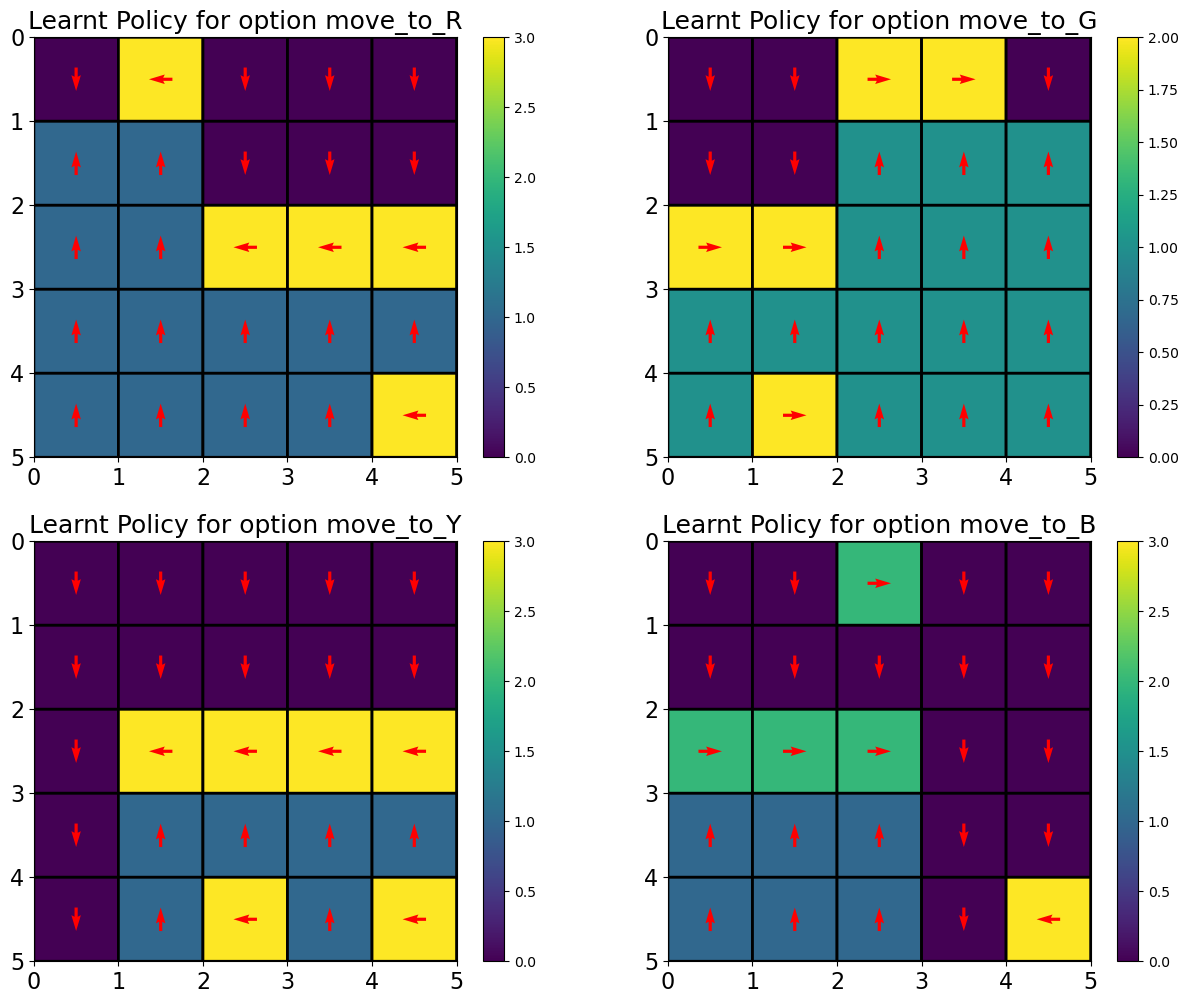

In [12]:
Options_list = ["move_to_R","move_to_G","move_to_Y","move_to_B"]
plt.figure(figsize=[15,12])
for i in range(1,5):
    plt.subplot(2,2,i)
    plot_policy(Options_Policy[i-1],message="Learnt Policy for option {}".format(Options_list[i-1]))
plt.savefig("Learnt_Options_Policy_2.png")